## Import

In [1]:
import os
import re
import argparse
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

font = {'family': 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## Config

In [2]:
data_root = 'data/results/aggreg'

extra_data = {
    'montage-chameleon-2mass-025d-001': { 'workflow_size': 619 },
    'montage-chameleon-dss-10d-001':    { 'workflow_size': 472 },
    'montage-chameleon-2mass-015d-001': { 'workflow_size': 310 },
    'montage-chameleon-dss-075d-001':   { 'workflow_size': 178 },
    'montage-chameleon-2mass-01d-001':  { 'workflow_size': 103 },
    'montage-chameleon-dss-05d-001':    { 'workflow_size': 58 },
}

# fifo | heft | min_min
sched_alg_name = 'fifo'

# 8 | 16 | 24
sys_cores = 8

# Each metric corresponds to three variations: _mean, _std, and _variance

# Metric 1                    Metric 2                    Metric 3                    Metric 4
# --------------------------------------------------------------------------------------------
# data_pages_migrations      data_pages_spreadings       threads_checksum            threads_active
# execs_active_count         reads_active_count          writes_active_count         numa_factor
# comp_to_comm               comm_to_comp                numa_awareness              makespan
# read_time_local            read_time_remote            read_time_total             write_time_local
# write_time_remote          write_time_total            compute_time_total          read_payload_local
# read_payload_remote        read_payload_total          write_payload_local         write_payload_remote
# write_payload_total        accesses_payload_local      accesses_payload_remote     accesses_payload_total
# compute_payload_total      read_accesses_local         read_accesses_remote        read_accesses_total
# write_accesses_local       write_accesses_remote       write_accesses_total        accesses_local
# accesses_remote            accesses_total              workflow_group_name         workflow_name
# test_conf_name             sched_alg_name              sys_cores                   workflow_size

col_name = 'makespan_mean'
col_units = 's'

# Comment if no figure is required
fig_output_file = f'{sched_alg_name}_{col_name}_{col_units}_{sys_cores}.pdf'

x_order = ['M', 'MA', 'SL', 'SR']
hue_order = ['C', 'S', 'L']

x_label = 'test_conf_name'
y_label = f"{col_name} ({col_units})"

## Helpers

In [3]:
def extract_data_to_dataframe(path, extra_data=None):
    series = pd.read_csv(path, header=None, index_col=0).iloc[:, 0]

    # Normalize path and split it
    parts = os.path.normpath(path).split(os.sep)

    # Extract workflow group
    workflow_group_name = parts[3].split('_')[0]

    # Extract workflow name
    workflow_name = parts[3].split('_')[1]

    # Example: 'min_min_16' → sched_alg_name = min_min, sys_cores = 16
    sched_part = parts[4]
    sched_alg_name, sys_cores = sched_part.rsplit('_', 1)

    # Extract test config name
    filename = os.path.splitext(parts[5])[0]
    test_conf_name = filename.split('_')[1]

    data = {
        'workflow_group_name': workflow_group_name,
        'workflow_name': workflow_name,
        'test_conf_name': test_conf_name,
        'sched_alg_name': sched_alg_name,
        'sys_cores': int(sys_cores)
    }

    df = pd.concat([series, pd.Series(data)]).to_frame().T

    if extra_data:
        df = df.assign(**extra_data[workflow_name])

    return df

## Dataframe

In [4]:
test_conf_names = list(Path(data_root).rglob('*.csv'))
df = pd.concat([ extract_data_to_dataframe(f, extra_data) for f in test_conf_names ])

df_cond = (df["sched_alg_name"] == sched_alg_name) & (df["sys_cores"] == sys_cores)
df = df[df_cond].copy()
df.head()

,data_pages_migrations_mean,data_pages_migrations_std,data_pages_migrations_variance,data_pages_spreadings_mean,data_pages_spreadings_std,data_pages_spreadings_variance,threads_checksum_mean,threads_checksum_std,threads_checksum_variance,threads_active_mean,...,accesses_remote_variance,accesses_total_mean,accesses_total_std,accesses_total_variance,workflow_group_name,workflow_name,test_conf_name,sched_alg_name,sys_cores,workflow_size
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,MA,fifo,8,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,M,fifo,8,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,SL,fifo,8,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,SR,fifo,8,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,462.0,0.0,0.0,C,montage-chameleon-2mass-01d-001,MA,fifo,8,103


## Figure

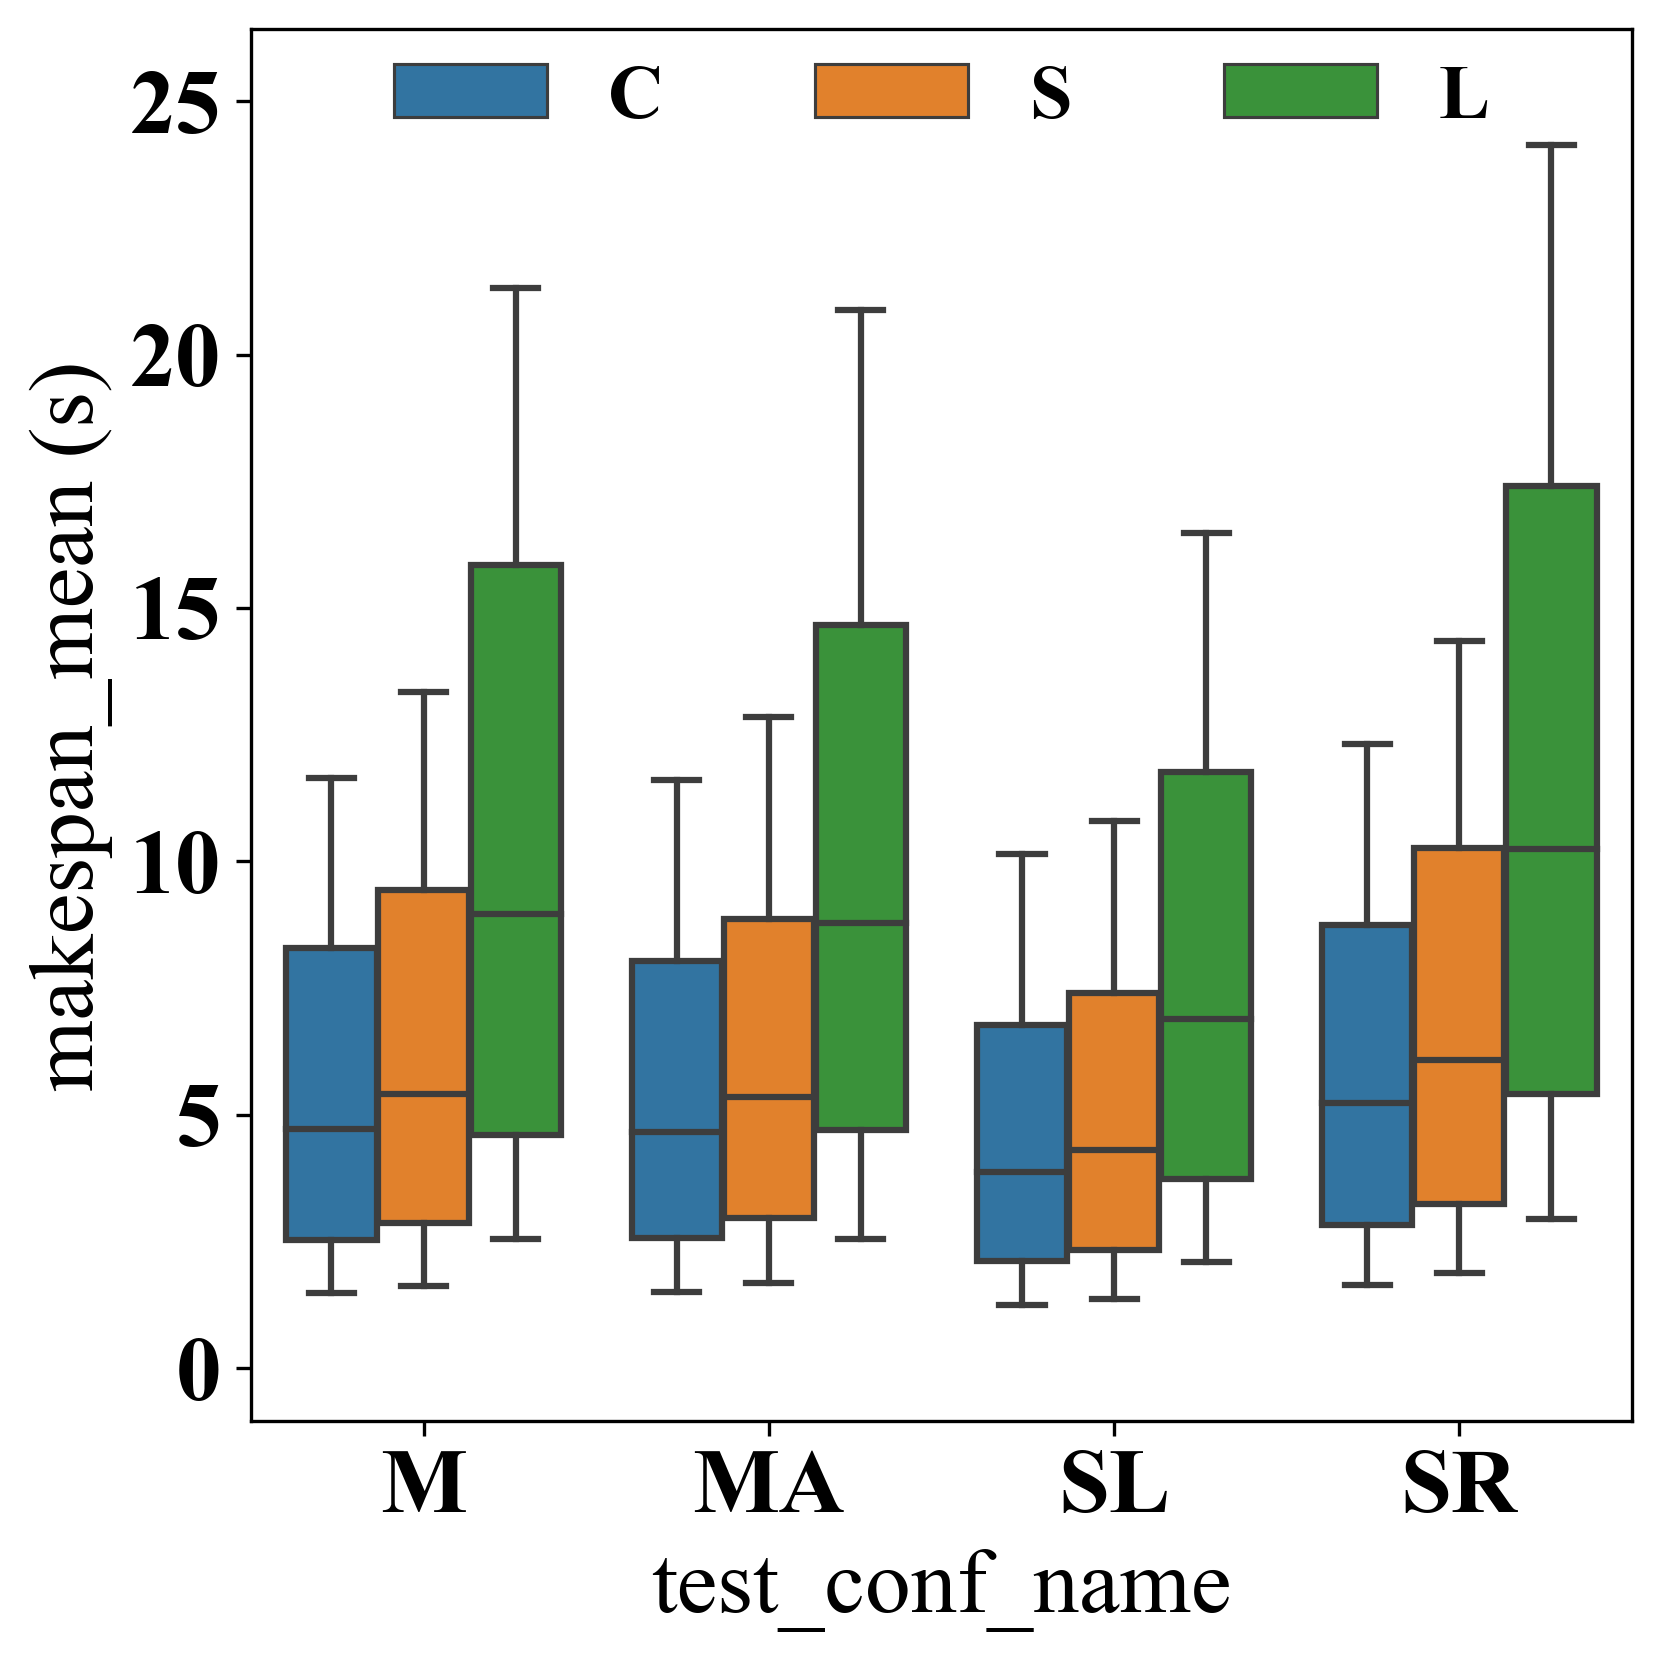

In [23]:
#sns.set(style="whitegrid")

plt.figure(figsize=(6, 6), dpi=300)

ax = sns.boxplot(data=df, x="test_conf_name", y="makespan_mean", hue='workflow_group_name', order=x_order, hue_order=hue_order)

plt.ylabel(y_label)
plt.xlabel(x_label)

plt.margins(y=0.1)
plt.tight_layout()

plt.legend(title='', bbox_to_anchor=(0.5, 0.95), loc='center', ncol=9, framealpha=0, fontsize='small')

if 'fig_output_file' in globals():
    plt.savefig(fig_output_file, dpi=300, bbox_inches='tight')